In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.linalg import svd, expm
import time

In [14]:
# Define functions

def syssim(M, N, dim_lat, nu):
    
    Z = np.zeros((dim_lat + nu, N))
    rho = 5  # Increasing rho increases excitation for better operator recovery
    Sigma = rho * np.eye(dim_lat + nu) + np.random.rand(dim_lat + nu, dim_lat + nu)
    Sigma_symm = ((1 / 2) * (Sigma + Sigma.T))
    Sigma_symm = ((dim_lat + nu) / np.trace(Sigma_symm)) * Sigma_symm

    for i in range(N):
        Z[:, i] = sqrtm(Sigma_symm).dot(np.random.normal(0, 1, dim_lat + nu))

    w = np.random.normal(0, 1, 1)
    Y = M.dot(Z) + w.reshape(-1, 1)

    return Z, Y
    
    

def subspace_distance(Phi_1, Phi_2):
    r = Phi_1.shape[0]
    distance = np.sqrt(r - np.linalg.norm(Phi_1.dot(Phi_2.T), 'fro') ** 2)
    return distance


def tasksgen(nx, nu, r, dim_lat, H, scale):
    # True representation
    Phi, _, _ = svd(np.random.randn(dim_lat + nu, dim_lat + nu))
    Phi = Phi[:r, :]
    
    
    Phi_true_sparse = np.zeros([Phi.shape[0],Phi.shape[1]])

    for i in range(Phi.shape[0]):
        for j in range(Phi.shape[1]):
            if Phi[i,j]<=0:
                Phi_true_sparse[i,j] = 0
            else:
                Phi_true_sparse[i,j] = Phi[i,j]

    Phi = Phi_true_sparse
    F_0 = np.random.randn(1, nu + nx)  # Nominal task weights F
    M_0 = F_0.dot(Phi)  # Nominal operator M

    # Generating different tasks weights
    F = []
    P = []
    for h in range(1, H + 1):
        L = scale * np.random.randn(1, 1)
        F.append(L*F_0)  # Generating the true weights for H different tasks

    M = []
    for h in range(H):
        M.append(F[h].dot(Phi))  # Generating the true operators M for H different tasks
    return M, Phi

def feature_whitened_alt_descent(Phi_hat, K, eta, H, M, Phi_true, nx, nu, N, dim_lat):
    F = [np.zeros((nx + nu, dim_lat + nu)) for _ in range(H)]
    Phi = [Phi_hat.copy() for _ in range(H)]
    Error_rep = np.zeros(K)

    for k in range(K):
        start_time = time.time()
        # Calculating subspace distance
        Error_rep[k] = subspace_distance(Phi_true, Phi_hat)
        

        # Initializing all the tasks with the same representation
        for h in range(H):
            Phi[h] = Phi_hat.copy()

        for h in range(H):
            # Sample a fresh data-set
            Z1, Y1 = syssim(M[h], N, dim_lat, nu)
            Z2, _ = syssim(M[h], N, dim_lat, nu)
            Z3, Y3 = syssim(M[h], N, dim_lat, nu)
            cov_sum = Z2.dot(Z2.T)

            # Computing Grad_Phi
            inv_term = np.linalg.inv(Phi[h].dot(Z1.dot(Z1.T)).dot(Phi[h].T))
            F[h] = Y1.dot(Z1.T).dot(Phi[h].T).dot(inv_term)
            Grad_Phi = (F[h].T.dot(F[h]).dot(Phi[h]).dot(Z3.dot(Z3.T)) - F[h].T.dot(Y3).dot(Z3.T)).dot(np.linalg.inv(cov_sum))
            Phi[h] -= eta * Grad_Phi

        # Aggregation
        Phi_avg = np.zeros((nx + nu, dim_lat + nu))
        for h in range(H):
            Phi_avg += (1 / H) * Phi[h]

        Q,R = np.linalg.qr(Phi_avg.T, mode='reduced')
        Phi_hat = Q.T
        
        end_time = time.time()
        print(f"Iteration: {k}, Error: {Error_rep[k]}, Time: {end_time - start_time}")
        
    return Error_rep


def alt_descent(Phi_hat, K, eta, H, M, Phi_true, nx, nu, N, dim_lat):
    F = [np.zeros((nx + nu, dim_lat + nu)) for _ in range(H)]
    Phi = [Phi_hat.copy() for _ in range(H)]
    Error_rep = np.zeros(K)

    for k in range(K):
        start_time = time.time()
        # Calculating subspace distance
        Error_rep[k] = subspace_distance(Phi_true, Phi_hat)

        # Initializing all the tasks with the same representation
        for h in range(H):
            Phi[h] = Phi_hat.copy()

        for h in range(H):
            # Sample a fresh data-set
            Z, Y = syssim(M[h], N, dim_lat, nu)

            # Computing F and Grad_Phi
            inv_term = np.linalg.inv(Phi[h].dot(Z.dot(Z.T)).dot(Phi[h].T))
            F[h] = Y.dot(Z.T).dot(Phi[h].T).dot(inv_term)
            Grad_Phi = (F[h].T.dot(F[h]).dot(Phi[h]).dot(Z.dot(Z.T)) - F[h].T.dot(Y).dot(Z.T))

            Phi[h] -= eta * Grad_Phi

        # Aggregation
        Phi_avg = np.zeros((nx + nu, dim_lat + nu))
        for h in range(H):
            Phi_avg += (1 / H) * Phi[h]

        Q,R = np.linalg.qr(Phi_avg.T, mode='reduced')
        Phi_hat = Q.T
        end_time = time.time()
        print(f"Iteration: {k}, Error: {Error_rep[k]}, Time: {end_time - start_time}")
    return Error_rep

$\textbf{System Parameter:}$

In [19]:
# System dimensions
nx = 5
nu = 2
r = nx + nu  # rank
dim_lat = 50  # dimension of the latent space
H = 10  # number of tasks
scale = 0.001  # scale of rotation

M, Phi_true = tasksgen(nx, nu, r, dim_lat, H, scale)

np.save('seed', {"M_list": M, "Phi_true": Phi_true})

nr = 1  # Number of systems realizations
K = 100  # number of global iterations
Error_r = []
N = 100  # number of samples

eta = 0.0075  # step-size

$\textbf{De-biasing and Feature Whitening:}$

In [20]:
L = np.random.randn(dim_lat + nu, dim_lat + nu)
skewL = (L - L.T) / 2
rot = expm(skewL)
Phi_hat = Phi_true.dot(rot)
Error_FW = feature_whitened_alt_descent(Phi_hat, K, eta, H, M, Phi_true, nx, nu, N, dim_lat)

Iteration: 0, Error: 2.5930298443259385, Time: 3.148151397705078
Iteration: 1, Error: 2.5261814680663917, Time: 3.032331705093384
Iteration: 2, Error: 2.526169274845459, Time: 3.1103150844573975
Iteration: 3, Error: 2.5261878386805128, Time: 3.050870180130005
Iteration: 4, Error: 2.5261890092659085, Time: 3.104229688644409
Iteration: 5, Error: 2.5261631474748434, Time: 3.051942825317383
Iteration: 6, Error: 2.526157839331102, Time: 3.067931652069092
Iteration: 7, Error: 2.526158927408884, Time: 3.241689682006836
Iteration: 8, Error: 2.5261516855646877, Time: 3.3063406944274902
Iteration: 9, Error: 2.5261586377533063, Time: 3.2492215633392334
Iteration: 10, Error: 2.5261220414369747, Time: 4.140712022781372
Iteration: 11, Error: 2.5261248668541305, Time: 3.9799256324768066
Iteration: 12, Error: 2.526120560756571, Time: 4.530455589294434
Iteration: 13, Error: 2.5261050660193822, Time: 4.684450149536133
Iteration: 14, Error: 2.526103884698896, Time: 4.642495632171631
Iteration: 15, Error:

$\textbf{Alternating Descent Minimization:}$

In [21]:
Error_WFW = np.zeros((nr, K))
H = 10
Error_WFW = alt_descent(Phi_hat, K, eta, H, M, Phi_true, nx, nu, N, dim_lat)

Iteration: 0, Error: 2.5930298443259385, Time: 1.1746044158935547
Iteration: 1, Error: 2.527282826077191, Time: 1.1925246715545654
Iteration: 2, Error: 2.529134243330335, Time: 1.1770226955413818
Iteration: 3, Error: 2.5304046531368822, Time: 1.322875738143921
Iteration: 4, Error: 2.5285469822525077, Time: 1.2809829711914062
Iteration: 5, Error: 2.526807496886845, Time: 1.382075548171997
Iteration: 6, Error: 2.5255666995448394, Time: 1.3672053813934326
Iteration: 7, Error: 2.525445304162789, Time: 1.1759839057922363
Iteration: 8, Error: 2.5250212848533073, Time: 1.1720964908599854
Iteration: 9, Error: 2.52452662189159, Time: 1.3034708499908447
Iteration: 10, Error: 2.52543567411201, Time: 1.4058187007904053
Iteration: 11, Error: 2.525550489929787, Time: 1.1425204277038574
Iteration: 12, Error: 2.524453322630142, Time: 1.2635836601257324
Iteration: 13, Error: 2.524567146937725, Time: 1.078498363494873
Iteration: 14, Error: 2.5240602639552745, Time: 1.098111867904663
Iteration: 15, Error

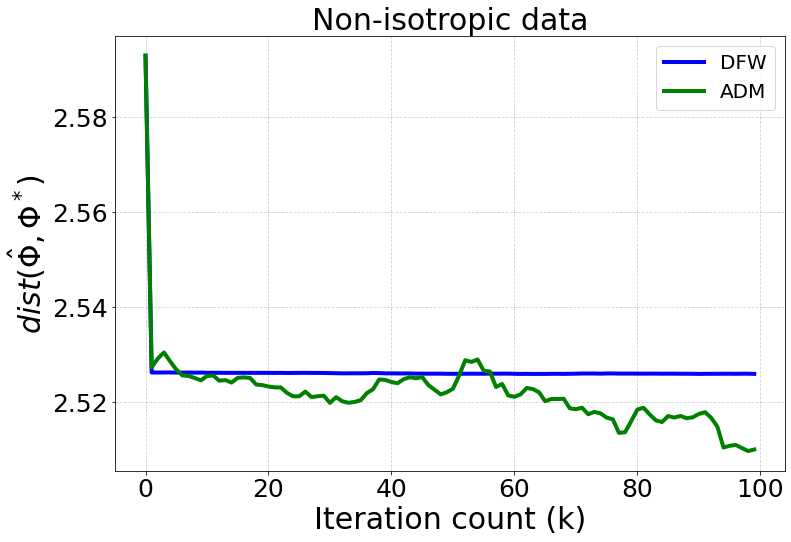

In [22]:
# Create a plot to show the convergence of the Gibbs Sampler (Log-joint vs iterations)
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(K))), Error_FW, label=r'DFW', color='blue', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_WFW, label=r'ADM',  color='green', linestyle='-', linewidth=4)

# Set labels and a title
ax.set_xlabel('Iteration count (k)',fontsize=30)
ax.set_ylabel(r'$dist(\hat{\Phi},\Phi^*)$',fontsize=30)
ax.tick_params(axis='both', labelsize=25)
ax.set_title(r'Non-isotropic data',fontsize=30)
plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:2]  
labels = labels[:2] 
plt.legend(handles=handles, labels=labels,fontsize=20)

# Customize the grid
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()